# Latent Variable Models: PCA to Kalman Filtering

In this notebook, we'll simulate a 2D latent dynamical system that generates high-dimensional observations, and then explore how different latent variable models (PCA, Factor Analysis, and Kalman Filtering) can be used to infer the hidden states.

We'll see how progressively richer statistical models help us recover latent structure more accurately by incorporating better probabilistic modeling and temporal dynamics.


In [1]:
import torch
import xfads.utils as utils
import xfads.plot_utils as plot_utils
import matplotlib.pyplot as plt
import xfads.prob_utils as prob_utils
import pytorch_lightning as lightning

from hydra import compose, initialize
from sklearn.decomposition import PCA
from xfads.linalg_utils import bmv, chol_bmv_solve, triangular_inverse
from xfads.prob_utils import kalman_information_filter, rts_smoother, align_latent_variables, construct_hankel

In [2]:

initialize(version_base=None, config_path="", job_name="lds")
cfg = compose(config_name="config")
lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

Seed set to 1234


## Simulating Data from a Latent Dynamical System
First, let's simulate data from a linear dynamical system; here, observations represent real valued 'neural activity' read out from a lower dimensional latent state.  This corresponds to a generative model formulated as,

$$
\begin{aligned}
\mathbf{z}_1 &\sim \mathcal{N}(0, \mathbf{Q}_0) \\\\
\mathbf{z}_t &= \mathbf{A} \mathbf{z}_{t-1} + \mathbf{w}_t \\\\
\mathbf{y}_t &= \mathbf{C} \mathbf{z}_t + \mathbf{v}_t
\end{aligned}
$$

where

$$
\begin{aligned}
\mathbf{w}_t &\sim \mathcal{N}(0, \mathbf{Q}) \\\\
\mathbf{v}_t &\sim \mathcal{N}(0, \mathbf{R})
\end{aligned}
$$

This synthetic setup mimics common situations in neuroscience and time-series analysis, where observed data are noisy and high-dimensional, but governed by low-dimensional latent dynamics.


In [50]:
# Simulation parameters
n_neurons = 50
n_trials = 1000
n_time_bins = 50
n_samples = 5

omega, rho = 3.14 / 8.0, 0.97
mean_fn = utils.SpiralDynamics(omega, rho)

C = torch.nn.Linear(2, n_neurons, device="cpu").requires_grad_(False)
# C = utils.FanInLinear(2, n_neurons, device="cpu").requires_grad_(False)
C.bias.data = torch.zeros_like(C.weight[:, 0])

Q_diag = 3e-2 * torch.ones(2)
Q_0_diag = 1.0 * torch.ones(2)
# R_diag = 0.8 * torch.ones(n_neurons)
R_diag = 0.5 + 0.5 * torch.rand(n_neurons)
m_0 = torch.zeros(2)

z = utils.sample_gauss_z(mean_fn, Q_diag, m_0, Q_0_diag, n_trials, n_time_bins)
y = C(z) + torch.sqrt(R_diag) * torch.randn_like(C(z))

# Split data
n_valid = n_trials // 3
n_train = n_trials - n_valid
y_train, z_train = y[:n_train], z[:n_train]
y_valid, z_valid = y[n_train:], z[n_train:]

## Visualize Simulated Data
### Single trial

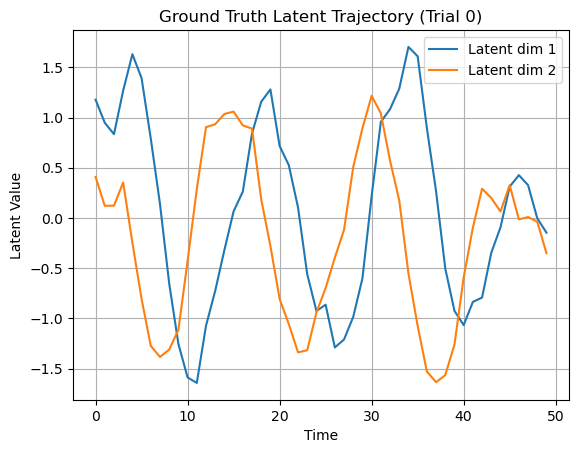

In [51]:
plt.plot(z[0, :, 0], label="Latent dim 1")
plt.plot(z[0, :, 1], label="Latent dim 2")
plt.legend()
plt.title("Ground Truth Latent Trajectory (Trial 0)")
plt.xlabel("Time")
plt.ylabel("Latent Value")
plt.grid(True)

### Multiple trials
Since this is a 2D example, we can look at multiple trajectories overlayed one another in state-space.

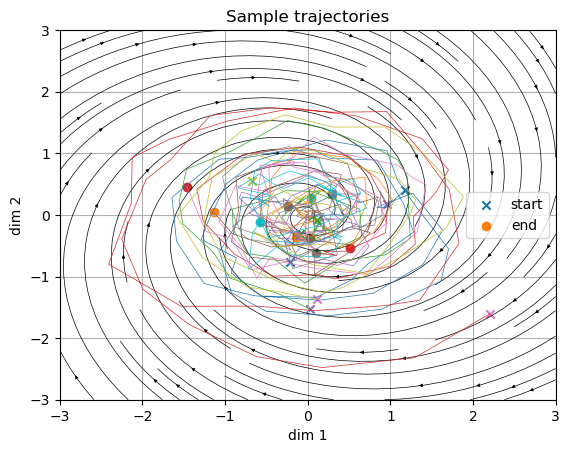

In [52]:
fig, axs = plt.subplots()
plot_utils.plot_two_d_vector_field(mean_fn, axs)

for i in range(10):
    axs.plot(z[i, :, 0], z[i, :, 1], linewidth=0.5)
    if i == 0:
        axs.scatter(z[i, 0, 0], z[i, 0, 1], marker='x', label='start')
        axs.scatter(z[i, -1, 0], z[i, -1, 1], marker='o', label='end')
    else:
        axs.scatter(z[i, 0, 0], z[i, 0, 1], marker='x')
        axs.scatter(z[i, -1, 0], z[i, -1, 1], marker='o')

axs.legend()
axs.set_title("Sample trajectories")
axs.set_xlabel("dim 1")
axs.set_ylabel("dim 2")
plt.grid(True)

## 1: Principal Component Analysis (PCA)

PCA is a classical linear method that finds directions of maximum variance in the data. While simple and efficient, it doesn't account for time or observation noise, and assumes the entire dataset lies on a linear subspace.  Still, PCA often works surprisingly well as a baseline. 

PCA can be related to a limiting case of a linear and Gaussian model where data is generated according to,

$$
\begin{aligned}
\mathbf{z} &\sim \mathcal{N}(0, \mathbf{I}) \\\\
\mathbf{y} \mid \mathbf{z} &\sim \mathcal{N}(\mathbf{C} \mathbf{z}, \sigma^2 \mathbf{I})
\end{aligned}
$$

where we take,

$$
\sigma^2 \rightarrow 0
$$



In [53]:
pca = PCA(n_components=2)
pca.fit(y_train.reshape(-1, n_neurons))
eig_vec = pca.components_
m_pca = pca.transform(y_valid.reshape(-1, n_neurons))
m_pca = torch.tensor(m_pca.reshape(n_valid, n_time_bins, -1), dtype=torch.float32)


Let's visualize the latent trajectories and the directions of maximum variance in the observed data

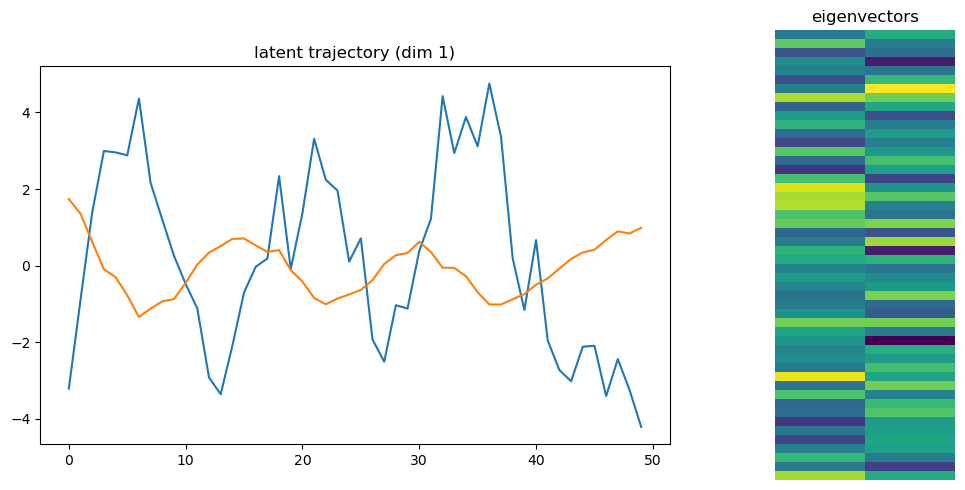

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Line plot
axs[0].set_title('latent trajectory (dim 1)')
axs[0].set_box_aspect(0.6)
axs[0].plot(m_pca[0, :, 0], label='pca')
axs[0].plot(z_valid[0, :, 0], label='true')

# Imshow - horizontally stretched
axs[1].imshow(eig_vec.T, aspect=0.1)
plot_utils.remove_axs_fluff(axs[1])
axs[1].set_title('eigenvectors')

plt.tight_layout()
plt.show()

Each column on the right is a particular 'principal component' and can be considered a dominant mode of instantaneous neural population activity; the left most column is the pattern of neural population activity that explains the most variance in the observed data. 

But is PCA doing a good job here at recovering the low-dimensional structure underlying the observed data? From the plot it looks like it's not -- however, this is because we have the freedom to rotate and scale the latent space arbitrarily.  Lets align these pca inferred 'latent trajectories' to the ground truth data,

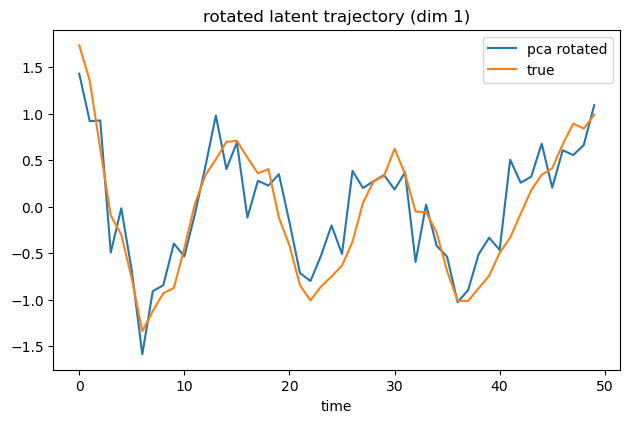

In [55]:
rot_pca, m_rot_pca = align_latent_variables(z_valid, m_pca)

fig, axs = plt.subplots(1, 1)

# Line plot
axs.set_title('rotated latent trajectory (dim 1)')
axs.set_box_aspect(0.6)
axs.plot(m_rot_pca[0, :, 0], label='pca rotated')
axs.plot(z_valid[0, :, 0], label='true')

axs.legend()
axs.set_xlabel('time')
plt.tight_layout()
plt.show()


looks better, but still not great -- let's examine a slightly more sophisticated statistical method.

## 2: Factor Analysis

Factor Analysis (FA) is another type of probabilistic generative model. It models the noise in each observation dimension and finds latent variables that explain shared structure across variables.  However, FA still treats each time point independently, ignoring dynamics entirely. The corresponding generative model for FA is,

$$
\begin{aligned}
\mathbf{z} &\sim \mathcal{N}(0, \mathbf{Q}) \\\\
\mathbf{y}\mid \mathbf{z} &\sim \mathcal{N}(\mathbf{C} \mathbf{z}, \mathbf{R})
\end{aligned}
$$

and the posterior, by Bayes' rule is, $p(\mathbf{z} \mid \mathbf{y}) \propto p(\mathbf{y}\mid \mathbf{z}) p(\mathbf{z})$, which can be found analytically through some Gaussian calculus as,

$$
\begin{aligned}
p(\mathbf{z}\mid \mathbf{y}) &= \mathcal{N}(\mathbf{m}, \mathbf{P})\\\\
\mathbf{P}^{-1} &= \mathbf{Q}^{-1} + \mathbf{C}^\top \mathbf{R}^{-1} \mathbf{C}\\\\
\mathbf{m} &= \mathbf{P} \mathbf{C}^\top \mathbf{R}^{-1} \mathbf{y}
\end{aligned}
$$

Let's compute posterior statistics given data and then use them to draw samples from the posterior.


In [56]:
# following the equations, find the precision and mean
J_fa = (C.weight.mT / R_diag) @ C.weight + torch.diag(1 / Q_diag)
J_fa_chol = torch.linalg.cholesky(J_fa)
P_fa_chol = triangular_inverse(J_fa_chol).mT
m_fa = chol_bmv_solve(J_fa_chol, bmv(C.weight.mT, (y_valid - C.bias)))
z_fa = m_fa.unsqueeze(0) + bmv(P_fa_chol, torch.randn((n_samples, n_valid, n_time_bins, cfg.n_latents)))

# don't forget to align!
rot_fa, m_rot_fa = align_latent_variables(z_valid, m_fa)
z_rot_fa = bmv(rot_fa, z_fa)


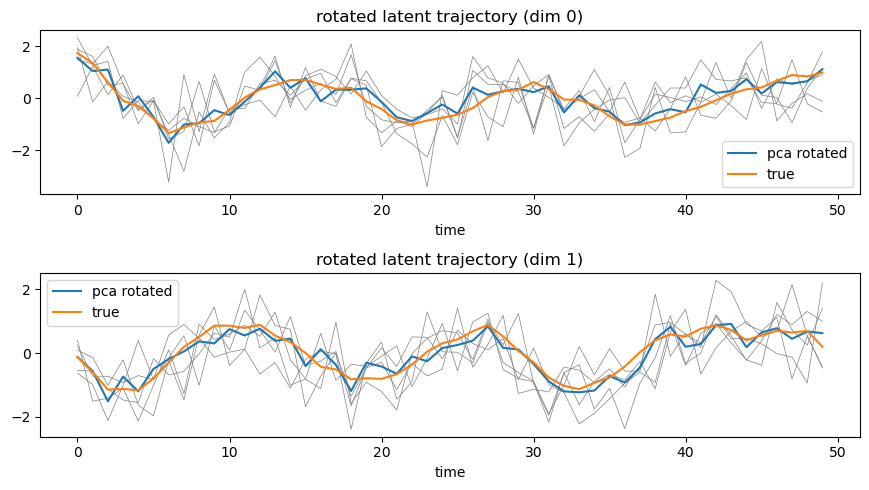

In [57]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))

for d in range(2):
    axs[d].set_title(f'rotated latent trajectory (dim {d})')
    axs[d].set_box_aspect(0.2)
        
    for s in range(n_samples):
        axs[d].plot(z_rot_fa[s, 0, :, d], linewidth=0.5, color='gray')
        
    axs[d].plot(m_rot_fa[0, :, d], label='pca rotated')
    
    axs[d].plot(z_valid[0, :, d], label='true')
    axs[d].legend()
    axs[d].set_xlabel('time')
    
plt.tight_layout()
plt.show()


looks much better than pca! factor analysis is better able to handle data with a higher SNR because the additional observation uncertainty is accounted for in the generative model. however, the ground truth trajectory is fairly smooth but samples from our posterior aren't -- factor analysis cannot account for the temporal structure underlying the data.

## 3: Kalman Filtering and Smoothing

Now, we'll account for temporal structure in the data by explicitly accounting for dynamics in the generative model -- specifically, we consider a probabilistic generative model where the latent state $\mathbf{z}_t$ evolves according to a linear stochastic difference equation and each observation $\mathbf{y}_t$ is linear and noisy readout of the latent state so that much like the data was generated we have,

$$
\begin{aligned}
\mathbf{z}_1 &\sim \mathcal{N}(0, \mathbf{Q}_0) \\\\
\mathbf{z}_t &= \mathbf{A} \mathbf{z}_{t-1} + \mathbf{w}_t \\\\
\mathbf{y}_t &= \mathbf{C} \mathbf{z}_t + \mathbf{v}_t
\end{aligned}
$$

where

$$
\begin{aligned}
\mathbf{w}_t &\sim \mathcal{N}(0, \mathbf{Q}) \\\\
\mathbf{v}_t &\sim \mathcal{N}(0, \mathbf{R})
\end{aligned}
$$

The Kalman filter is a recursive algorithm for calculating the statistics of the posterior 'filtering' distribution, which by linearity and Gaussianity of the system will also be Gaussian, which we specify by,

$$
\begin{aligned}
p(\mathbf{z}_t\mid \mathbf{y}_{1:t}) &= \mathcal{N}(\breve{\mathbf{m}}_t, \breve{\mathbf{P}}_t)
\end{aligned}
$$

From these statistics, and a new observation, $\mathbf{y}_{t+1}$, we want to update our posterior belief about $\mathbf{z}_{t+1}$.  The great thing is that Baye's rule tells us exactly how to do this, since

$$
\begin{aligned}
    p(\mathbf{z}_{t+1} \mid \mathbf{y}_{1:t+1}) &\propto p(\mathbf{y}_{t+1} \mid \mathbf{z}_{t+1}) p(\mathbf{z}_{t+1} \mid \mathbf{y}_{1:t})
\end{aligned}
$$

We know how to do this Gaussian calculus, but, we don't know $p(\mathbf{z}_{t+1}\mid \mathbf{y}_{1:t})$, so lets find that first using quantities we already know,

$$
\begin{aligned}
p(\mathbf{z}_{t+1}\mid \mathbf{y}_{1:t}) &= \int p(\mathbf{z}_{t+1}, \mathbf{z}_t\mid \mathbf{y}_{1:t}) \, d \mathbf{z}_t \\\\
 \text{} &= \int p(\mathbf{z}_{t+1} \mid  \mathbf{z}_t) p(\mathbf{z}_t \mid \mathbf{y}_{1:t}) \, d\mathbf{z}_t \\\\
\text{} &= \mathcal{N}(\bar{\mathbf{m}}_{t+1}, \bar{\mathbf{P}}_{t+1})
\end{aligned}
$$

where
$$
\begin{aligned}
\bar{\mathbf{m}}_{t+1} &= \mathbf{A} \breve{\mathbf{m}}_t\\\\
\bar{\mathbf{P}}_{t+1} &= \mathbf{A} \breve{\mathbf{P}}_t \mathbf{A}^{\top} + \mathbf{Q} 
\end{aligned}
$$

Notice that the predictive distribution mean and covariance are an affine combination of the filtered mean and covariance respectively.  Finally, we return to our posterior update equation and some Gaussian calculus again,

$$
\begin{aligned}
    p(\mathbf{z}_{t+1} \mid \mathbf{y}_{1:t+1}) &= \mathcal{N}(\mathbf{m}_{t+1}, \mathbf{P}_{t+1})\\\\
    \mathbf{P}_{t+1}^{-1} &= \mathbf{Q}^{-1} + \mathbf{C}^\top \mathbf{R}^{-1} \mathbf{C}\\\\
    \mathbf{m}_{t+1} &= \mathbf{P}_{t+1} (\bar{\mathbf{P}}_{t+1}^{-1} \bar{\mathbf{m}}_{t+1} + \mathbf{C}^\top \mathbf{R}^{-1} \mathbf{y}_{t+1})
\end{aligned}
$$

In [58]:
h_update = bmv(C.weight.T, (y_valid - C.bias) / R_diag)
J_update = (C.weight.T / R_diag) @ C.weight
J_update = J_update.expand(y_valid.shape[0], n_time_bins, cfg.n_latents, cfg.n_latents)

m_f, P_f, m_p, P_p = kalman_information_filter(h_update, J_update, mean_fn.A, Q_diag, m_0, Q_0_diag)
m_s, P_s, P_tp1_t_s, z_s = rts_smoother(m_p, P_p, m_f, P_f, mean_fn.A, n_samples=n_samples)
rot_s, m_rot_s = align_latent_variables(z_valid, m_s)
z_rot_s = bmv(rot_s, z_s)

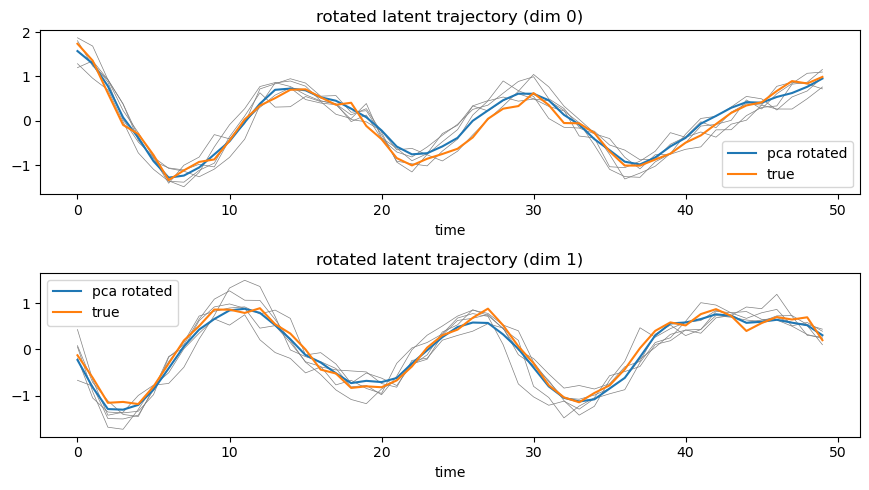

In [59]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))

for d in range(2):
    axs[d].set_title(f'rotated latent trajectory (dim {d})')
    axs[d].set_box_aspect(0.2)
        
    for s in range(n_samples):
        axs[d].plot(z_rot_s[s, 0, :, d], linewidth=0.5, color='gray')
        
    axs[d].plot(m_rot_s[0, :, d], label='pca rotated')
    
    axs[d].plot(z_valid[0, :, d], label='true')
    axs[d].legend()
    axs[d].set_xlabel('time')
    
plt.tight_layout()
plt.show()

look how much smoother the posterior samples are!

## Comparisons

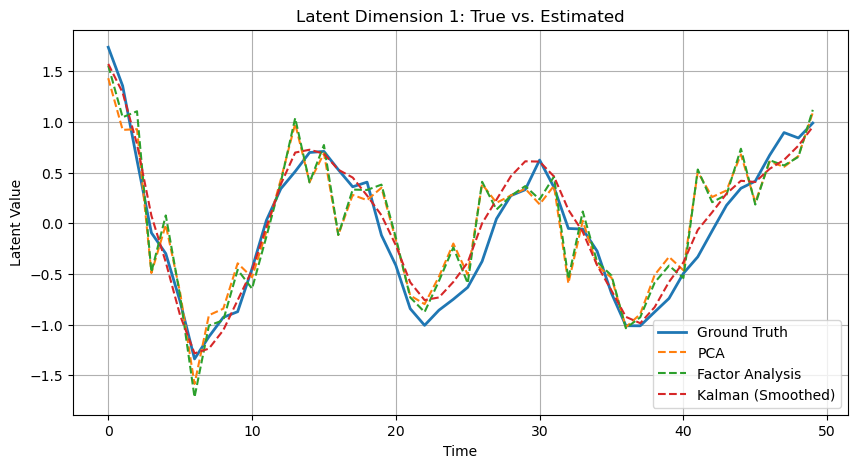

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(z_valid[0, :, 0], label='Ground Truth', linewidth=2)
plt.plot(m_rot_pca[0, :, 0], label='PCA', linestyle='--')
plt.plot(m_rot_fa[0, :, 0], label='Factor Analysis', linestyle='--')
plt.plot(m_rot_s[0, :, 0], label='Kalman (Smoothed)', linestyle='--')
plt.title("Latent Dimension 1: True vs. Estimated")
plt.xlabel("Time")
plt.ylabel("Latent Value")
plt.legend()
plt.grid(True)

# Learning Latent Dynamics Parameters

So far, we assumed access to the true dynamics and observation parameters. But in practice, these must be estimated from data.

We'll now explore two approaches for learning the parameters of a Linear Dynamical System (LDS):

1. **System Identification** using the **Kalman-Ho algorithm** (a subspace method).
2. **Expectation-Maximization (EM)** for LDS parameter learning (a probabilistic approach).

We'll compare their learned state transition matrices via their eigenvalues.


## Kalman-Ho System Identification

The Kalman-Ho algorithm is a classic subspace identification method. It works by constructing a Hankel matrix from the observed outputs and applying an SVD to extract latent dynamics.

This method is fast and often used in control and system ID applications.


# Kalman–Ho Algorithm: Derivation and Parameter Estimation

We consider the linear–Gaussian state-space model:

$$
\begin{aligned}
z_1 &\sim \mathcal{N}(0, P_{\infty})\\
z_{t+1} &= A z_t + w_t, \quad w_t \sim \mathcal{N}(0, Q) \\
y_t &= C z_t + v_t, \quad v_t \sim \mathcal{N}(0, R)
\end{aligned}
$$

We assume stationarity, and so $
\mathbb{E}[z_t z_t^{\top}] = P_{\infty}$ where,  $\( P_\infty \)$ satisfies the discrete Lyapunov equation:

$$
P_\infty = A P_\infty A^\top + Q
$$

---

## Step 1: Estimate Output Covariances

Given output sequences $\( \{ y_t \} \)$, compute empirical covariances:

$$
\Gamma_k := \mathbb{E}[y_{t+k} y_t^\top] \approx \frac{1}{T - k} \sum_{t=1}^{T-k} y_{t+k} y_t^\top, \quad k = 0, 1, \dots, K
$$

---

## Step 2: Build the Hankel Matrix

Construct the block Hankel matrix:

$$
H =
\begin{bmatrix}
\Gamma_1 & \Gamma_2 & \dots & \Gamma_k \\
\Gamma_2 & \Gamma_3 & \dots & \Gamma_{k+1} \\
\vdots & \vdots & \ddots & \vdots \\
\Gamma_j & \Gamma_{j+1} & \dots & \Gamma_{j+k-1}
\end{bmatrix}
= \mathcal{O} \mathcal{K}
$$

where:

- $\( \mathcal{O} \)$: observability matrix
$$
\mathcal{O} =
\begin{bmatrix}
C \\
C A \\
\vdots \\
C A^{j-1}
\end{bmatrix}
$$

- $\( \mathcal{K} \)$: reversed controllability matrix
$$
\mathcal{K} =
\begin{bmatrix}
A^{k-1} P_\infty C^\top & \cdots & P_\infty C^\top
\end{bmatrix}
$$

---

## Step 3: Perform Low-Rank Factorization via SVD

Compute the singular value decomposition:

$$
H \approx U \Sigma V^\top
$$

Truncate to rank-\( d \), and define:

$$
\mathcal{O} = U_d \Sigma_d^{1/2}, \quad \mathcal{K} = \Sigma_d^{1/2} V_d^\top
$$

---

## Step 4: Estimate System Matrices \( A \) and \( C \)

Extract $\( C \)$ from the first block row of $\( \mathcal{O} \)$.  
Estimate $\( A \)$ using shifted observability blocks:

$$
\mathcal{O}_{\text{next}} = \mathcal{O}_{\text{prev}} A
\quad \Rightarrow \quad
A = \left( \mathcal{O}_{\text{prev}} \right)^\dagger \mathcal{O}_{\text{next}}
$$

---

## Step 5: Estimate Stationary Latent Covariance $\( P_\infty \)$

Using:

$$
\Gamma_k = C A^k P_\infty C^\top
$$

Vectorize:

$$
\text{vec}(\Gamma_k) = (C^\top \otimes C A^k) \cdot \text{vec}(P_\infty)
$$

Stack across $\( k = 0, \dots, K \)$ and solve the linear system:

$$
\mathbf{g} = \mathbf{M} \cdot \text{vec}(P_\infty)
\quad \Rightarrow \quad
\text{vec}(\hat{P}_\infty) = (\mathbf{M}^\top \mathbf{M})^{-1} \mathbf{M}^\top \mathbf{g}
$$

Reshape into matrix form.

---

## Step 6: Estimate Observation Noise Covariance \( R \)

From the autocovariance at lag 0:

$$
\Gamma_0 = C P_\infty C^\top + R
\quad \Rightarrow \quad
\boxed{R = \Gamma_0 - C P_\infty C^\top}
$$

---

## Step 7 (Optional): Estimate Process Noise Covariance \( Q \)

From the Lyapunov equation:

$$
P_\infty = A P_\infty A^\top + Q
\quad \Rightarrow \quad
\boxed{Q = P_\infty - A P_\infty A^\top}
$$

---

> ✅ **Note**: All recovered parameters are up to a similarity transform in latent space. Symmetrize and ensure positive semi-definiteness of \( \hat{Q} \) and \( \hat{R} \) after estimation if necessary.


In [61]:
# Construct Hankel matrix
H_hankel = prob_utils.construct_hankel(y_valid, 50, 50)
Gamma_0_hat = prob_utils.compute_gamma_0(y_valid.reshape(-1, n_neurons))

# Estimate system matrices using Kalman-Ho
A_hat_kh, B_hat_kh, C_hat_kh, Q_hat_kh, R_hat_kh = prob_utils.get_kalman_ho_estimates(
    H_hankel, Gamma_0_hat, n_neurons, cfg.n_latents
)
R_diag_kh = torch.diag(R_hat_kh)
Q_diag_kh = torch.diag(Q_hat_kh)

# Eigenvalues of learned A
eig_vals_kh_hat = torch.linalg.eigvals(A_hat_kh)

Lets compare Kalman filtering with identity dynamics versus those inferred by the Ho-Kalman algorithm

In [67]:
hk_update = bmv(C_hat_kh.T, y_valid / R_diag_kh) # C bias is 0
Jk_update = (C_hat_kh.T @ R_hat_kh) @ C_hat_kh
Jk_update = Jk_update.expand(y_valid.shape[0], n_time_bins, cfg.n_latents, cfg.n_latents)

m_f_hk, P_f_hk, m_p_hk, P_p_hk = kalman_information_filter(h_update, J_update, A_hat_kh, Q_diag_kh, m_0, Q_0_diag)
m_s_hk, P_s_hk, P_tp1_t_s_hk, z_s_hk = rts_smoother(m_p_hk, P_p_hk, m_f_hk, P_f_hk, A_hat_kh, n_samples=n_samples)
rot_s_hk, m_rot_s_hk = align_latent_variables(z_valid, m_s_hk)
z_rot_s_hk = bmv(rot_s_hk, z_s_hk)

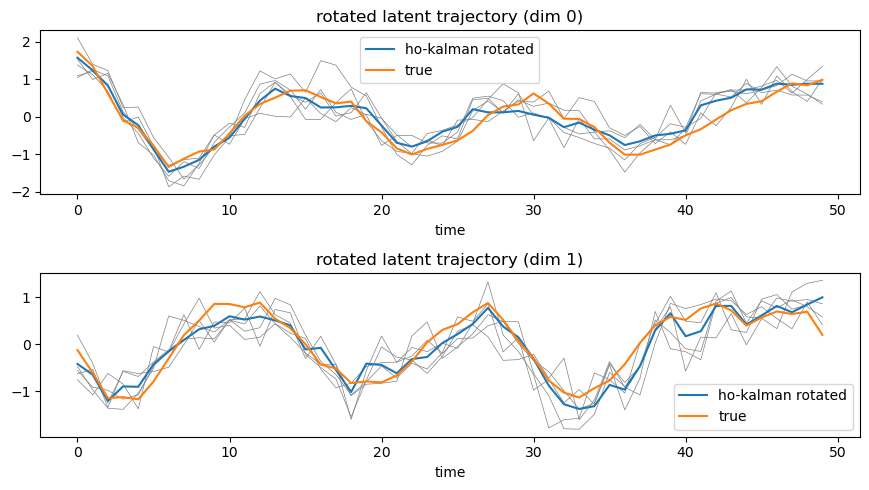

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))

for d in range(2):
    axs[d].set_title(f'rotated latent trajectory (dim {d})')
    axs[d].set_box_aspect(0.2)
        
    for s in range(n_samples):
        axs[d].plot(z_rot_s_hk[s, 0, :, d], linewidth=0.5, color='gray')
        
    axs[d].plot(m_rot_s_hk[0, :, d], label='ho-kalman rotated')
    
    axs[d].plot(z_valid[0, :, d], label='true')
    axs[d].legend()
    axs[d].set_xlabel('time')
    
plt.tight_layout()
plt.show()

In [71]:
R_hat_eye = torch.ones(n_neurons)
A_hat_eye = torch.eye(cfg.n_latents)
C_hat_eye = torch.nn.Linear(cfg.n_latents, n_neurons, bias=False, device=hk_update.device).requires_grad_(False)
heye_update = bmv(C_hat_eye.weight.T, y_valid / R_diag) # C bias is 0
Jeye_update = (C_hat_eye.weight.T / R_hat_eye) @ C_hat_eye.weight
Jeye_update = Jeye_update.expand(y_valid.shape[0], n_time_bins, cfg.n_latents, cfg.n_latents)

m_f_eye, P_f_eye, m_p_eye, P_p_eye = kalman_information_filter(heye_update, Jeye_update, A_hat_eye, Q_diag, m_0, Q_0_diag)
m_s_eye, P_s_eye, P_tp1_t_s_eye, z_s_eye = rts_smoother(m_p_eye, P_p_eye, m_f_eye, P_f_eye, A_hat_eye, n_samples=n_samples)
rot_s_eye, m_rot_s_eye = align_latent_variables(z_valid, m_s_eye)
z_rot_s_eye = bmv(rot_s_eye, z_s_eye)


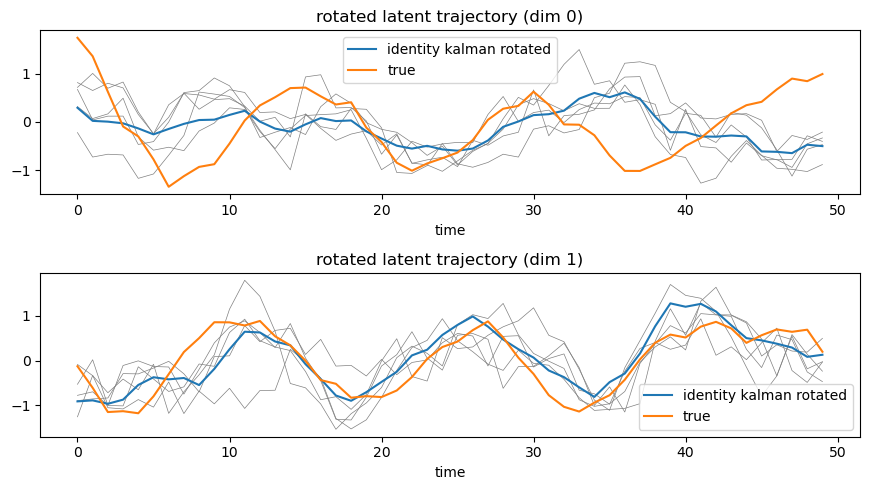

In [72]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))

for d in range(2):
    axs[d].set_title(f'rotated latent trajectory (dim {d})')
    axs[d].set_box_aspect(0.2)
        
    for s in range(n_samples):
        axs[d].plot(z_rot_s_eye[s, 0, :, d], linewidth=0.5, color='gray')
        
    axs[d].plot(m_rot_s_eye[0, :, d], label='identity kalman rotated')
    
    axs[d].plot(z_valid[0, :, d], label='true')
    axs[d].legend()
    axs[d].set_xlabel('time')
    
plt.tight_layout()
plt.show()

## EM for LDS Parameter Estimation

The EM algorithm is a probabilistic approach to estimating LDS parameters. It alternates between:

- **E-step**: Inferring latent trajectories (here, using RTS smoothing).
- **M-step**: Updating parameters to maximize the expected complete-data log-likelihood.

This method can be more accurate and flexible, especially with noise or missing data.


In [73]:
# Estimate parameters using EM
A_hat_em, C_hat_em, Q_hat_em, R_hat_em = prob_utils.em_update_batch(m_s, P_s, P_tp1_t_s, y_valid)

# Eigenvalues of learned A
eig_vals_em_hat = torch.linalg.eigvals(A_hat_em)
